# Aggregate-Label Learning (Draft)

A reproduction of the aggregate-label learning task using an implementation of the multi-spike tempotron in Julia. 

For further details see [Gütig, R. (2016). Spiking neurons can discover predictive features by aggregate-label learning. Science, 351(6277), aab4113.](https://science.sciencemag.org/content/351/6277/aab4113)

## Imports

In [37]:
using Tempotrons
using Tempotrons.InputGen
using Tempotrons.Plots
using Tempotrons.Optimizers
using Random
using ProgressMeter
using Plots
using Plots.PlotMeasures;

## Set parameters

In [38]:
N                = 500                       # number of afferent neurons
T                = 500                       # base input duration (in ms)
dt               = 1                         # time precision (in ms, for visualization purposes)
ν                = 5                         # background/event firing frequency (in Hz)
λ                = 1e-5                      # learning rate
opt              = SGD(λ, momentum = 0.99)   # optimizer
Nᶠ               = 10                        # number of event types
Tᶠ               = 50                        # event duration (in ms)
Cᶠ_mean          = 0.5                       # mean number of event ocurrances per sample per event type
n_steps          = 20000                     # number of training samples
n_train_samples  = 10000                      # number of training samples
n_test_samples   = 10                        # number of test samples
tmp              = Tempotron(N = N, τₘ = 20) # the multi-spike tempotron
Pretrain!(tmp);                              # initialize the tempotron's weights by a pretraining process (see original paper for details)

## Set teacher's rule
Numbered examples follow [Fig.1](https://science.sciencemag.org/content/351/6277/aab4113#F2)(B) from the [original paper](https://science.sciencemag.org/content/351/6277/aab4113). 

In [39]:
# y₀(event_types)::Integer = isempty(event_types) ? 0 : length(filter(x -> x == 2, event_types));   #1
# y₀(event_types)::Integer = isempty(event_types) ? 0 : 5*length(filter(x -> x == 2, event_types)); #2
# y₀(event_types)::Integer = isempty(event_types) ? 0 : length(filter(x -> x%2 == 0, event_types)); #3
y₀(event_types)::Integer = isempty(event_types) ? 0 : sum(filter(x -> x%2 == 0, event_types)/2);  #4

## Generate samples

### Input events

In [40]:
events = GetEvents(Nᶠ = Nᶠ, Tᶠ = Tᶠ, N = N, ν = ν);

### Test samples

In [41]:
test_samples = [GenerateSampleWithEmbeddedEvents(events, Tᶠ = Tᶠ, Cᶠ_mean = Cᶠ_mean, ν = ν, T = T)
                for j = 1:(n_test_samples - 1)]
push!(test_samples, GenerateSampleWithEmbeddedEvents(events, Tᶠ = Tᶠ, Cᶠ_mean = 0.1, ν = ν, T = 5Tᶠ, test = true))
test_samples = [(ts..., 
                 y = y₀(ts.event_types), 
                 t = collect(0:dt:maximum(abs, maximum.(abs, ts.x))))
                for ts ∈ test_samples];

In [42]:
# # Prepare to plot
# plotlyjs(size = (800, 1500))
# cols = collect(1:Nᶠ)#palette(:rainbow, Nᶠ)
# test_events = [[(time = s.event_times[i], length = Tᶠ, color = cols[s.event_types[i]])
#                 for i = 1:length(s.event_times)] 
#                for s ∈ test_samples]
# neur_disp = randsubseq(1:N, 0.1)

# # Plots
# inp_plots = [PlotInputs(test_samples[i].x, events = test_events[i], reduce_afferents = neur_disp)
#              for i = 1:length(test_samples)]
# p = plot(inp_plots[1:(end - 1)]..., layout = (length(inp_plots) - 1, 1), link = :all)
# plot(p, inp_plots[end], layout = grid(2, 1, heights = [1 - 1/length(inp_plots), 
#      1/length(inp_plots)]), bottom_margin = 12mm, fmt = :svg)

### Training samples

In [43]:
train_samples = @showprogress 1 "Generating samples..." [GenerateSampleWithEmbeddedEvents(events, Tᶠ = Tᶠ, 
                                                                                          Cᶠ_mean = Cᶠ_mean, 
                                                                                          ν = ν, T = T)
                                                         for j = 1:n_train_samples]
train_samples = [(x = ts.x, y = y₀(ts.event_types))
                 for ts ∈ train_samples];

Generating samples...100%|██████████████████████████████| Time: 0:02:26


## Train

In [44]:
# Train the tempotron
@showprogress 1 "Training..." for i = 1:n_steps
    s = rand(train_samples)
    Train!(tmp, s.x, s.y, optimizer = opt)
end

Training...100%|████████████████████████████████████████| Time: 0:28:27


## Plots

#### Get voltage traces for the test samples

In [45]:
out_a = @showprogress 1 "Evaluating test samples..." [tmp(s.x, t = s.t) for s ∈ test_samples];

Evaluating test samples...100%|█████████████████████████| Time: 0:00:09


#### Prepare to plot

In [46]:
plotlyjs(size = (800, 1500))
cols = collect(1:Nᶠ)#palette(:rainbow, Nᶠ)
test_events = [[(time = s.event_times[i], length = Tᶠ, color = cols[s.event_types[i]])
                for i = 1:length(s.event_times)] 
               for s ∈ test_samples]
neur_disp = randsubseq(1:N, 0.1);

#### Plot

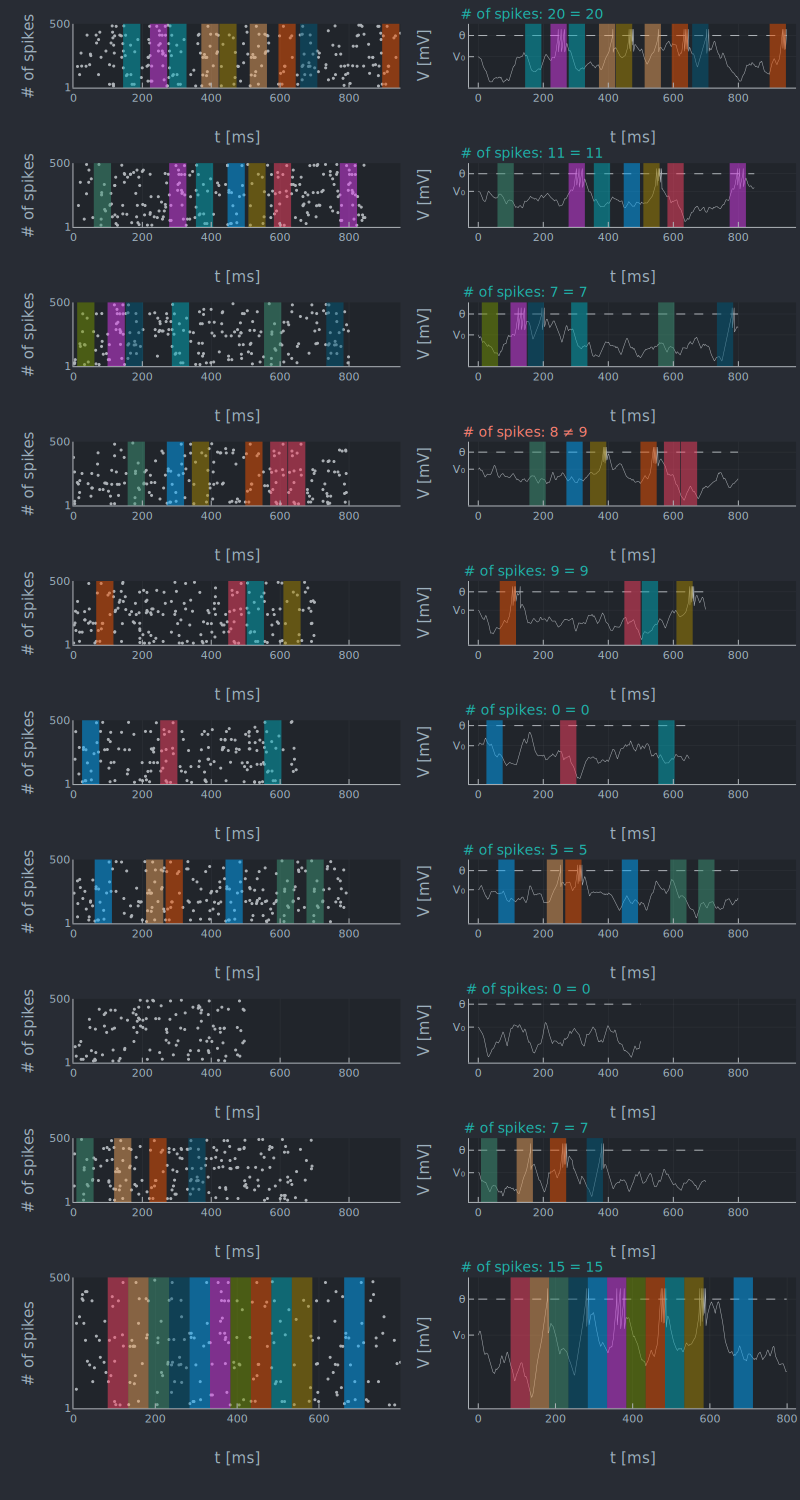

In [47]:
inp_plots = [PlotInputs(test_samples[i].x, events = test_events[i], reduce_afferents = neur_disp)
             for i = 1:length(test_samples)]
train_plots = [PlotPotential(tmp, out = out_a[i].V, N = length(out_a[i].spikes), 
                             N_t = test_samples[i].y,
                             t = test_samples[i].t, events = test_events[i])
               for i = 1:length(test_samples)]
ip = plot(inp_plots[1:(end - 1)]..., layout = (length(inp_plots) - 1, 1), link = :all)
tp = plot(train_plots[1:(end - 1)]..., layout = (length(train_plots) - 1, 1), link = :all)
p = plot(ip, tp, layout = (1, 2), link = :all)
pe = plot(inp_plots[end], train_plots[end], layout = (1, 2), link = :all)
plot(p, pe, layout = grid(2, 1, heights = [1 - 1/length(inp_plots), 1/length(inp_plots)]), 
     left_margin = 8mm, bottom_margin = 12mm, fmt = :svg)

In [48]:
savefig("Results\\AggLabels.svg");
savefig("Results\\AggLabels.png");